# Contextual Overrotation

In this notebook, we will focus on the adjustment of the overrotation angle that is dependent of a parametrized quantum gate.
Specifically, we model at the pulse level the implementation of a $RX$ gate by setting the amplitude of the pulse to be proportional to the angle of rotation. We add artifically an overrotation that is actually dependent on the angle of rotation, i.e $U_{err}=RX(γθ)$.


In [1]:
import numpy as np
from rl_qoc import ContextAwareQuantumEnvironment
from qiskit.circuit import QuantumCircuit, Parameter

from rl_qoc.helper_functions import get_q_env_config, load_from_yaml_file

# Custom RX gate

In the configuration we define a custom backend whose particularity is to have a custom RX gate.
We first calibrate the X and SX gate based on traditional Rabi sweep of the amplitude of a DRAG Pulse (followed by a calibration of the DRAG coefficient). Then, the custom RX gate is calibrated by setting the amplitude of the pulse to be proportional to the angle of rotation, i.e. $RX(\theta) \equiv DRAG(amp = \frac{X_{amp}}{\pi} θ)$. Since we consider a contextual overrotation, we add to the custom RX gate a small amplitude error proportional to $\theta$, with $amp_{err} = γ \frac{X_{amp}}{\pi} θ$. Finally, $RX_{err}(\theta) \equiv DRAG(amp = \frac{X_{amp}}{\pi} θ (1 + γ))$.

We test out the custom RX gate by running a circuit with a RX gate and measuring the output state. We then calculate the state fidelity and gate fidelity of the output state with respect to the target state and target gate, respectively.

In [116]:
from typing import Optional
from qiskit.providers import BackendV2
from qiskit import pulse
from qiskit.transpiler import InstructionProperties
from rl_qoc.helper_functions import convert_solver_options, perform_standard_calibrations
from qiskit.circuit.library.standard_gates import RXGate


def get_backend(
        γ: float = 0.1,
        **backend_params,
) -> Optional[BackendV2]:
    """
    Define backend on which the calibration is performed.
    This function uses data from the yaml file to define the backend.
    If provided parameters on the backend are null, then the user should provide a custom backend instance.
    :param real_backend: If True, then calibration is performed on real quantum hardware, otherwise on simulator
    :param backend_name: Name of the backend to be used, if None, then least busy backend is used
    :param use_dynamics: If True, then DynamicsBackend is used, otherwise standard backend is used
    :param physical_qubits: Physical qubits indices to be used for the calibration
    :param channel: Qiskit Runtime Channel  (for real backend)
    :param instance: Qiskit Runtime Instance (for real backend)
    :param solver_options: Options for the DynamicsBackend solver
    :param calibration_files: Path to the calibration files (for DynamicsBackend)
    :return: Backend instance
    """

    # Propose here your custom backend, for Dynamics we take for instance the configuration from dynamics_config.py
    from pulse_level.qiskit_pulse.dynamics_backends import (
        fixed_frequency_transmon_backend,
    )

    if "solver_options" in backend_params:
        solver_options = backend_params["solver_options"]
    else:
        solver_options = {"method": "jax_odeint",
                          "atol": 1e-8,
                          "rtol": 1e-8,
                          "hmax": 1e-10, }

    calibration_files = backend_params.get("calibration_files", None)
    # TODO: Add here your custom backend
    dt = 2.2222e-10
    dims = [2]
    freqs = [4.86e9]
    anharmonicities = [-0.33e9]
    rabi_freqs = [0.22e9]
    solver_options = convert_solver_options(solver_options, dt=dt)
    backend = fixed_frequency_transmon_backend(
        dims, freqs, anharmonicities, rabi_freqs, solver_options=solver_options
    )
    # backend = single_qubit_backend(5, 0.1, 1 / 4.5)[1]
    # backend = surface_code_plaquette()[0]
    cals, exps = perform_standard_calibrations(backend, calibration_files)

    # Add a calibration for RX gate (through amplitude modulation)
    x_cal = backend.target.get_calibration("x", (0,))
    x_pulse: pulse.Drag = x_cal.instructions[0][1].pulse
    new_parameters = x_pulse.parameters.copy()

    pi_amp = x_pulse.amp  # Amplitude for pi pulse
    θ = Parameter("θ")
    rx_amp = pi_amp * θ / np.pi  # Amplitude for the RX gate

    overrotation_amp = γ * rx_amp
    rx_amp += overrotation_amp
    new_parameters["amp"] = rx_amp

    with pulse.build(backend, name="rx_sched") as rx_sched:
        pulse.play(pulse.Drag(**new_parameters), pulse.drive_channel(0))

    instruction_prop = InstructionProperties(
        duration=rx_sched.duration * backend.dt, calibration=rx_sched
    )
    backend.target.add_instruction(RXGate(θ), {(0,): instruction_prop})

    return backend

In [128]:
# Hyperparameters
seed = 42
np.random.seed(seed)
γ = np.random.uniform(0.2, 0.5)  # Overrotation factor
ϕ = Parameter("ϕ")
ϕ_val = np.random.uniform(0, np.pi)
n_reps = 1

print('γ =', γ)
print('ϕ =', ϕ_val, f'= π/{np.pi / ϕ_val}')

γ = 0.3123620356542088
ϕ = 2.9867570806801083 = π/1.0518406983652073


In [143]:
# Import configuration
from pulse_level.qiskit_pulse.x_calibration.contextual_coherent_error.contextual_overrotation_config import (
    get_circuit_context,
    apply_parametrized_circuit,
)
from functools import partial

config_file_path = "q_env_pulse_config.yml"

q_env_config = get_q_env_config(
    config_file_path, partial(get_backend, γ=γ), apply_parametrized_circuit
)

q_env_config.backend_config.parametrized_circuit_kwargs = {
    "target": q_env_config.target,
    "backend": q_env_config.backend,
}

Custom backend used
Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'rz', 'h', 'reset', 'sdg', 's', 't', 'sx', 'measure', 'tdg', 'id', 'delay', 'z', 'x'}
Multi qubit instructions:
)>


In [144]:
cals, exp = perform_standard_calibrations(q_env_config.backend)

Starting Rabi experiment for qubit 0...
Rabi experiment for qubit 0 done.
Starting Drag experiment for qubit 0...
Drag experiments done for qubit 0 done.
All single qubit calibrations are done
Updated Instruction Schedule Map <InstructionScheduleMap(1Q instructions:
  q0: {'rz', 'h', 'reset', 'sdg', 's', 't', 'rx', 'sx', 'measure', 'tdg', 'id', 'delay', 'z', 'x'}
Multi qubit instructions:
)>


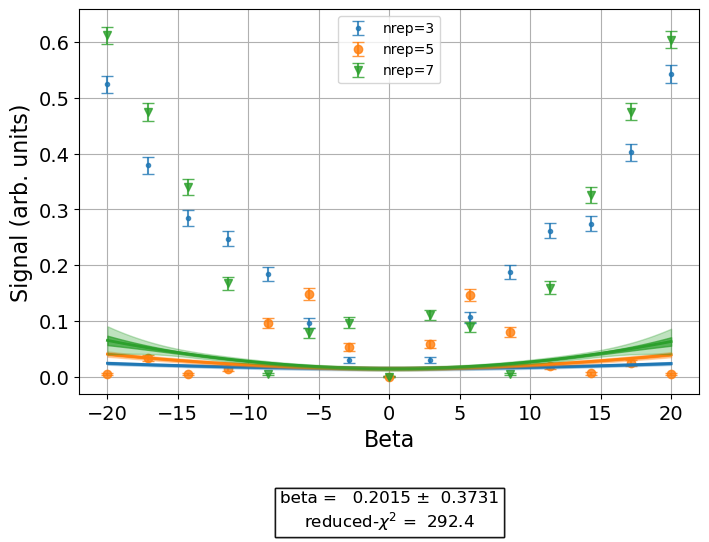

In [145]:
exp[0][1].figure(0)

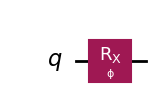

In [146]:
# Test out the custom RX gate
noiseless_qc = QuantumCircuit(1, name="noiseless_rx")
noise_qc = QuantumCircuit(1, name="noise_rx")
for _ in range(n_reps):
    noiseless_qc.rx(ϕ, 0)
    noise_qc.rx(ϕ, 0)

noiseless_qc.draw("mpl")


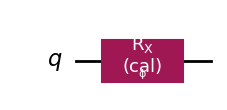

In [147]:
# Add custom calibration of RX (without over rotation) 
backend = q_env_config.backend
x_cal = backend.target.get_calibration("x", (0,))
x_pulse: pulse.Drag = x_cal.instructions[0][1].pulse
new_parameters = x_pulse.parameters.copy()

pi_amp = x_pulse.amp  # Amplitude for pi pulse
rx_amp = (pi_amp / np.pi) * ϕ  # Amplitude for the RX gate

new_parameters["amp"] = rx_amp

with pulse.build(backend, name="rx_sched") as rx_sched:
    pulse.play(pulse.Drag(**new_parameters), pulse.DriveChannel(0))

noiseless_qc.add_calibration("rx", (0,), rx_sched, [ϕ])
noiseless_qc.draw("mpl")


In [148]:
noiseless_qc.calibrations

{'rx': {((0,),
   (Parameter(ϕ),)): ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=0.2014640202, amp=0.0377512564732034*ϕ, angle=0), DriveChannel(0)), name="rx_sched", transform=AlignLeft())}}

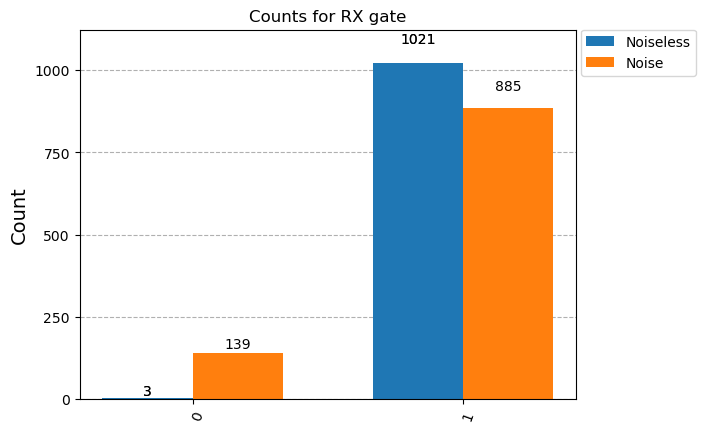

In [149]:
# Run the circuit with the noiseless RX gate
from qiskit.visualization import plot_histogram

assigned_noiseless_qc = noiseless_qc.assign_parameters({ϕ: ϕ_val}, inplace=False)
assigned_noise_qc = noise_qc.assign_parameters({ϕ: ϕ_val}, inplace=False)
noiseless_job = backend.run(assigned_noiseless_qc.measure_all(False), shots=1024)
noiseless_counts = noiseless_job.result().get_counts()
noise_job = backend.run(assigned_noise_qc.measure_all(False), shots=1024)
noise_counts = noise_job.result().get_counts()
plot_histogram([noiseless_counts, noise_counts], legend=["Noiseless", "Noise"], title="Counts for RX gate")

In [150]:
from qiskit_dynamics import DynamicsBackend
from qiskit.quantum_info import Operator, Statevector, state_fidelity, average_gate_fidelity
from rl_qoc.helper_functions import fidelity_from_tomography

backend: DynamicsBackend = q_env_config.backend
noisy_state, noiseless_state = backend.solve([assigned_noise_qc, assigned_noiseless_qc], y0=Statevector.from_label("0"))
noisy_gate, noiseless_gate = backend.solve([assigned_noise_qc, assigned_noiseless_qc], y0=Operator.from_label("0"))
noisy_state = noisy_state.y[-1] / np.linalg.norm(noisy_state.y[-1])
noiseless_state = noiseless_state.y[-1] / np.linalg.norm(noiseless_state.y[-1])
noisy_gate = noisy_gate.y[-1]
noiseless_gate = noiseless_gate.y[-1]

target_state = Statevector(assigned_noiseless_qc.remove_final_measurements(False))
target_gate = Operator(assigned_noiseless_qc.remove_final_measurements(False))

function_inputs = {"backend": backend, "physical_qubits": [0]}
noisy_state_fid, noisy_gate_fid = [fidelity_from_tomography(qc_input=assigned_noise_qc.remove_final_measurements(False),
                                                            target=tgt_type(
                                                                assigned_noise_qc.remove_final_measurements(False)),
                                                            **function_inputs) for tgt_type in [Statevector, Operator]]
noiseless_state_fid, noiseless_gate_fid = [
    fidelity_from_tomography(qc_input=assigned_noiseless_qc.remove_final_measurements(False),
                             target=tgt_type(assigned_noiseless_qc.remove_final_measurements(False)),
                             **function_inputs) for tgt_type in [Statevector, Operator]]
print(f"State fidelity (noisy sim): {state_fidelity(noisy_state, target_state)}")
print(f"Gate fidelity (noisy sim): {average_gate_fidelity(noisy_gate, target_gate)}")
print(f"State fidelity (noisy tomography): {noisy_state_fid}")
print(f"Gate fidelity (noisy tomography): {noisy_gate_fid}")
print(f"State fidelity (noiseless sim): {state_fidelity(noiseless_state, target_state)}")
print(f"Gate fidelity (noiseless sim): {average_gate_fidelity(noiseless_gate, target_gate)}")
print(f"State fidelity (noiseless tomography): {noiseless_state_fid}")
print(f"Gate fidelity (noiseless tomography): {noiseless_gate_fid}")



State fidelity (noisy sim): 0.7987289731289201
Gate fidelity (noisy sim): 0.46641877290946226
State fidelity (noisy tomography): [0.8053579348600128]
Gate fidelity (noisy tomography): 0.8608283340577948
State fidelity (noiseless sim): 0.9999750020102074
Gate fidelity (noiseless sim): 0.500001713552504
State fidelity (noiseless tomography): [0.9992113981942099]
Gate fidelity (noiseless tomography): 0.9934390961131987


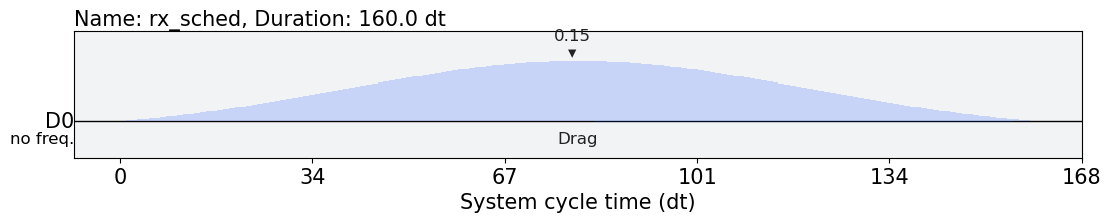

In [138]:
from qiskit.transpiler import Target
from qiskit.visualization.pulse_v2 import IQXDebugging

backend_target: Target = q_env_config.backend.target
backend_target.get_calibration('rx', (0,), ϕ_val).draw(style=IQXDebugging())

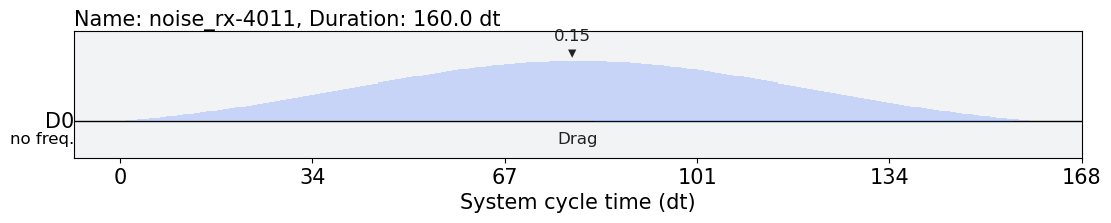

In [141]:
from qiskit import schedule

schedule(assigned_noise_qc, backend).draw(style=IQXDebugging())

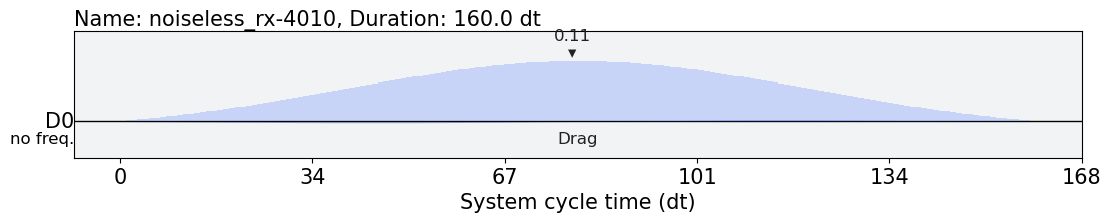

In [142]:
schedule(assigned_noiseless_qc, backend).draw(style=IQXDebugging())

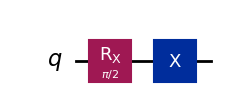

In [19]:
# Circuit context
ϕ = np.pi / 2
circuit_context = get_circuit_context(ϕ)
circuit_context.draw("mpl")

In [20]:
from gymnasium.wrappers import RescaleAction, ClipAction

q_env = ContextAwareQuantumEnvironment(q_env_config, circuit_context)
rescaled_env = RescaleAction(ClipAction(q_env), -1, 1)

In [21]:
from rl_qoc import CustomGateReplacementPass
from qiskit.circuit.library import XGate

pass_ = CustomGateReplacementPass(
    [("x", (0,))],
    [apply_parametrized_circuit],
    [q_env.parameters[0]],
    [q_env._func_args],
)

In [9]:
q_env.target_instruction

CircuitInstruction(operation=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(1, 'q'), 0),), clbits=())

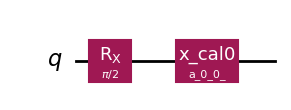

In [16]:
from qiskit.transpiler import PassManager

pm = PassManager(pass_)
pm.run(circuit_context).draw("mpl")

In [17]:
# Agent
from rl_qoc import CustomPPO
from rl_qoc.ppo_config import TrainingConfig, TrainFunctionSettings, TotalUpdates

agent_config = load_from_yaml_file("agent_config.yaml")
training_config = TrainingConfig(TotalUpdates(5))
train_function_settings = TrainFunctionSettings(
    plot_real_time=True, clear_history=False, num_prints=10
)
ppo_agent = CustomPPO(agent_config, rescaled_env)

In [18]:
ppo_agent.train(training_config, train_function_settings)

2024-10-08 13:53:45 INFO Training Constraint: Total Updates


ValueError: I/O operation on closed file

In [11]:
# Original fidelity
from rl_qoc.helper_functions import fidelity_from_tomography
from qiskit.quantum_info import Operator, Statevector

state_fidelity = fidelity_from_tomography(
    q_env.baseline_circuits[0],
    q_env_config.backend,
    Statevector(q_env.baseline_circuits[0]),
    [0],
)
gate_fidelity = fidelity_from_tomography(
    q_env.baseline_circuits[0],
    q_env_config.backend,
    Operator(q_env.baseline_circuits[0]),
    [0],
)
print(f"State fidelity: {state_fidelity}")

print(f"Gate fidelity: {gate_fidelity}")

State fidelity: [0.9951171875000004]
Gate fidelity: 0.9938171518218096


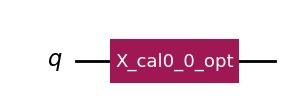

In [13]:
q_env.update_gate_calibration()
qc = QuantumCircuit(1)
qc.append(q_env.new_gates[0], [0])
qc.draw("mpl")
# Update calibration

In [14]:
# New fidelity
from rl_qoc.helper_functions import fidelity_from_tomography
from qiskit.quantum_info import Operator, Statevector

state_fidelity = fidelity_from_tomography(
    qc, q_env_config.backend, Statevector(q_env.baseline_circuits[0]), [0]
)
gate_fidelity = fidelity_from_tomography(
    qc, q_env_config.backend, Operator(q_env.baseline_circuits[0]), [0]
)
print(f"State fidelity: {state_fidelity}")

print(f"Gate fidelity: {gate_fidelity}")

State fidelity: [0.2182570960098271]
Gate fidelity: 0.4831910759815234


In [15]:
q_env.backend.operation_names

['measure',
 'z',
 's',
 'sdg',
 't',
 'tdg',
 'rz',
 'id',
 'h',
 'x',
 'sx',
 'reset',
 'delay',
 'rx',
 'x_cal0',
 'x_cal0_0_opt']

In [16]:
q_env.backend.operations

[Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]),
 Instruction(name='z', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='s', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='sdg', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='t', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='tdg', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]),
 Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='h', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='x', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]),
 Delay(duration=t[unit=dt]),
 Instruction(name='rx', num_qubits=1, num_clbits=0, params=[Parameter(θ)]),
 Instruction(name='x_cal0', num_qubits=1, num_clbits=0, params=[Parameter(a_0_0_)]),
 Instruction(name='x_cal0

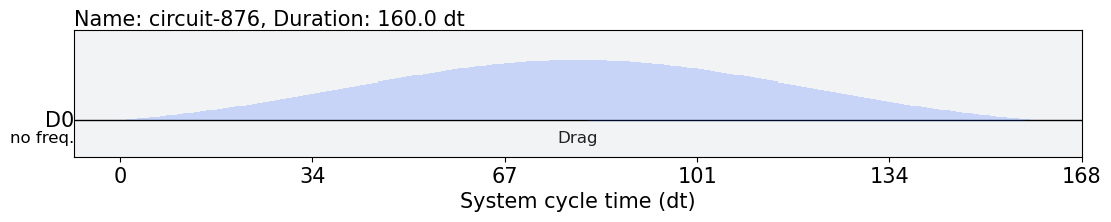

In [15]:
q_env.backend.target.get_calibration("x_cal0", (0,)).draw()

[Instruction(name='x_cal0', num_qubits=1, num_clbits=0, params=[Parameter(a_0_0_)])]